# HEADSS2 Demo
This notebook goes through the key functionality of HEADSS2. For a more detailed background as well as the API reference, see the official [documentation](https://headss2.readthedocs.io/en/latest/).

## Example datasets
HEADSS2 comes with ten example datasets


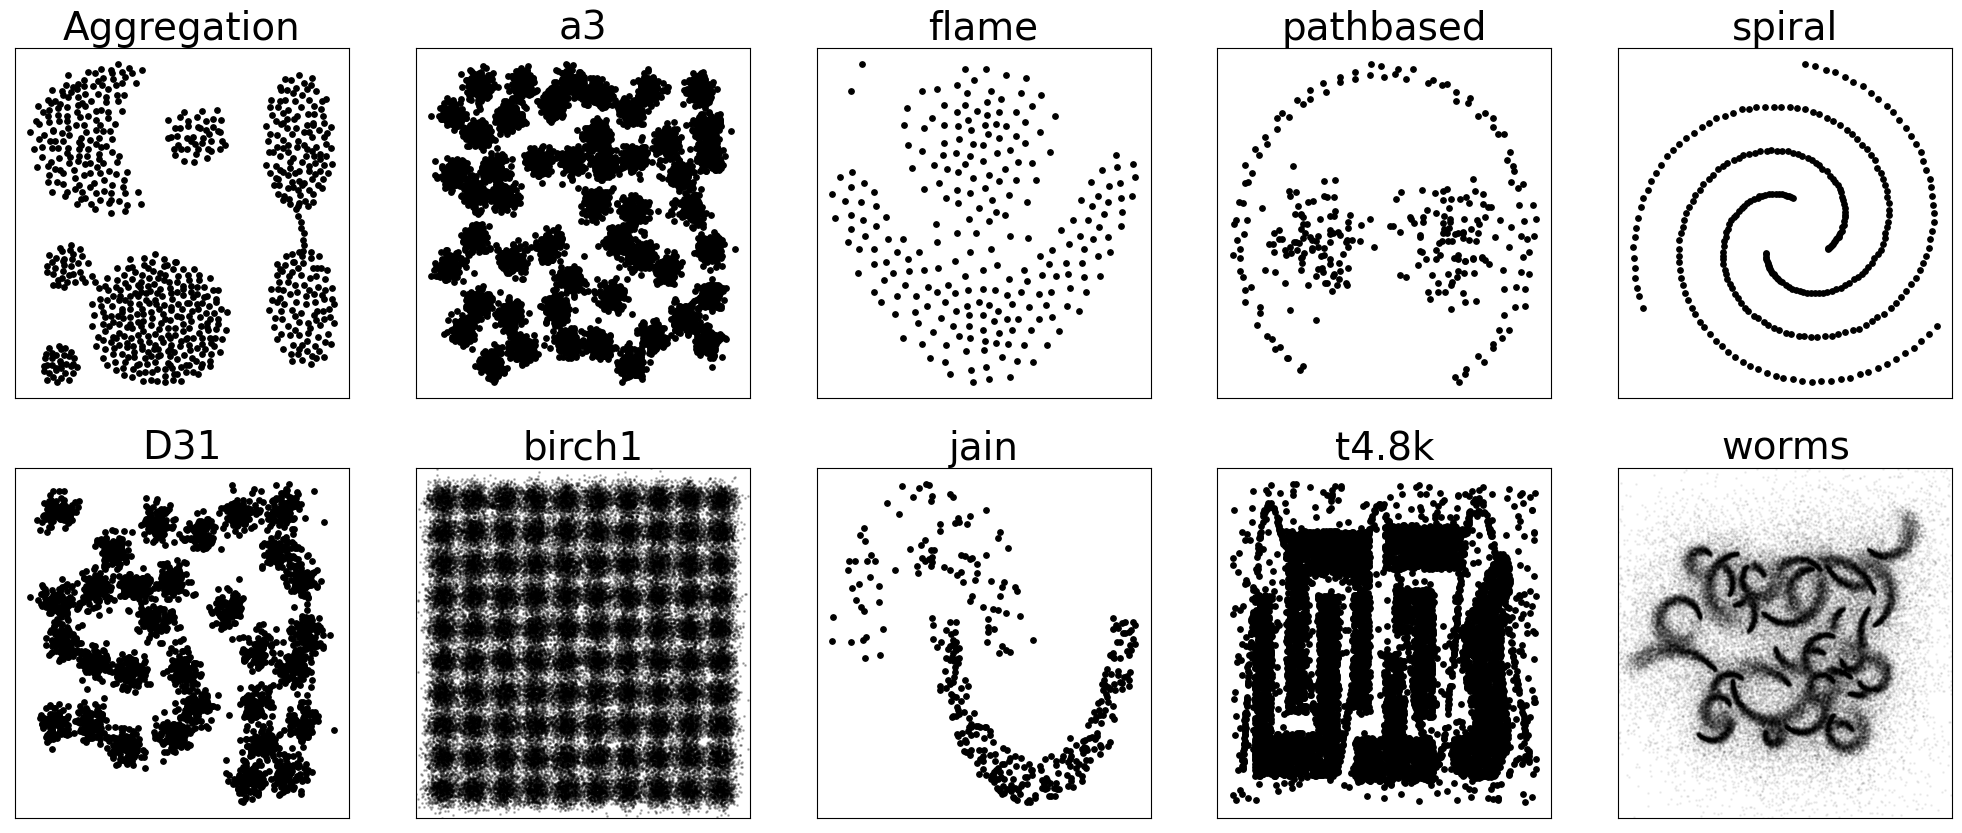

In [4]:
display(HTML('''
    <script>
        code_show=true;
        function code_toggle() {
         if (code_show){
           $('div.input').hide();
         } else {
           $('div.input').show();
         }
         code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
'''))

import base64
from IPython.display import HTML

with open("datasets.png", "rb") as image_file:
    encoded = base64.b64encode(image_file.read()).decode('utf-8')

HTML(f'<img src="data:image/png;base64,{encoded}" />')


The `dataset(name)` function retrieves each dataset as a Pandas dataframe. 

In [17]:
from headss2 import dataset
dataset("D31")

,x,y
0,25.0514,5.7475
1,26.6614,7.3414
2,25.2653,6.2466
3,25.2285,4.7447
4,25.7529,5.1564
...,...,...
3095,5.1380,16.6150
3096,5.7360,16.9991
3097,5.2760,17.2475
3098,6.4444,16.2033


Note the use of an underscore instead of a full stop in the name of `t4_8k`

In [18]:
dataset("t4_8k")

,x,y
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


## Making regions

In [19]:
a3 = dataset("a3")

In [20]:
from headss2 import make_regions

In [21]:
regs_a3 = make_regions(df = a3, 
             n = 2,   # number of cuts in base layer
             split_columns = ['x', 'y'])  # columns to be used for splitting

`make_regions` returns a `Regions` object, with two attributes: `split_data` (dataset partitioned into regions) and `split_regions` (summary statistics about each region)

In [22]:
regs_a3.split_data

,x,y,region
0,8960,29349,0
1,9566,30666,0
2,10002,29085,0
3,9051,28004,0
4,8262,29745,0
...,...,...,...
17088,42558,33844,8
17089,45411,33445,8
17090,45644,35586,8
17091,42617,35670,8


In [23]:
regs_a3.split_regions

,region,x_mins,y_mins,x_max,y_max
0,0,0.00,976.0,32767.50,32559.0
1,1,0.00,16767.5,32767.50,48350.5
2,2,0.00,32559.0,32767.50,64142.0
3,3,16383.75,976.0,49151.25,32559.0
4,4,16383.75,16767.5,49151.25,48350.5
5,5,16383.75,32559.0,49151.25,64142.0
6,6,32767.50,976.0,65535.00,32559.0
7,7,32767.50,16767.5,65535.00,48350.5
8,8,32767.50,32559.0,65535.00,64142.0


## Clustering with HDBSCAN

This module is just a wrapper around HDBSCAN, so to select appropriate parameters for your dataset, please refer to the [HDBSCAN documentation](https://hdbscan.readthedocs.io/en/latest/index.html).

In [24]:
from headss2 import cluster
clustered_a3 = cluster(split_data=regs_a3.split_data,
        min_cluster_size=10,
        min_samples=None,
        cluster_method='eom',
        allow_single_cluster=False,
        cluster_columns=['x', 'y'])

In [25]:
clustered_a3

,x,y,region,group
0,8960,29349,0,1
1,9566,30666,0,1
2,10002,29085,0,1
3,9051,28004,0,1
4,8262,29745,0,1
...,...,...,...,...
15449,42558,33844,8,104
15450,45411,33445,8,104
15451,45644,35586,8,104
15452,42617,35670,8,104


## Stitching
Stitching refers to the process of joining the regions that have each been processed in parallel. There are no parameters for users to fine tune at this stage

In [26]:
from headss2 import stitch
stitch(clustered_data=clustered_a3,
       split_columns=['x', 'y'],
       stitch_regions=regs_a3.stitch_regions)

,x,y,region,group
148,4764,24290,0,2
149,3241,23730,0,2
150,3373,24827,0,2
151,894,24681,0,2
152,5567,22531,0,2
...,...,...,...,...
15312,48382,60296,8,102
15313,47369,59613,8,102
15314,45278,59639,8,102
15315,48789,60495,8,102


## Merging

Finally, HEADSS2 can identify overlapping clusters and merge them to improve results.

`a3` does not require merging, so we are going to use `t4_8k` for this.

First, we'll need to make regions, cluster, and stitch the data as before:

In [27]:
t4_8k = dataset("t4_8k")

regs_t4_8k = make_regions(df=t4_8k, n=2, split_columns=['x', 'y'])

clustered_t4_8k = cluster(split_data=regs_t4_8k.split_data,
                          cluster_columns=['x', 'y'],
                          min_cluster_size=30,
                          min_samples=10,
                          cluster_method='eom',
                          allow_single_cluster=False)

stitched_t4_8k = stitch(clustered_data=clustered_t4_8k,
                        split_columns=['x', 'y'],
                        stitch_regions=regs_t4_8k.stitch_regions)

Then perform the merging. See the [documentation](https://headss2.readthedocs.io/en/latest/) for details on these parameters.

In [28]:
from headss2 import merge_clusters

merged_t4_8k = merge_clusters(
    clustered=stitched_t4_8k,
    group_col="group",
    split_regions=regs_t4_8k.split_regions,
    split_columns=["x", "y"],
    minimum_members=10,
    overlap_threshold=0.5,
    total_threshold=0.1,
    n_cores=1
)

#### Before merging:

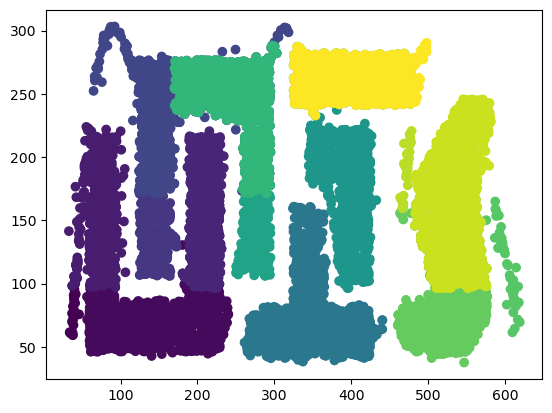

In [29]:
import matplotlib.pyplot as plt
plt.scatter(stitched_t4_8k.x, stitched_t4_8k.y, c = stitched_t4_8k.group)

#### With merging:

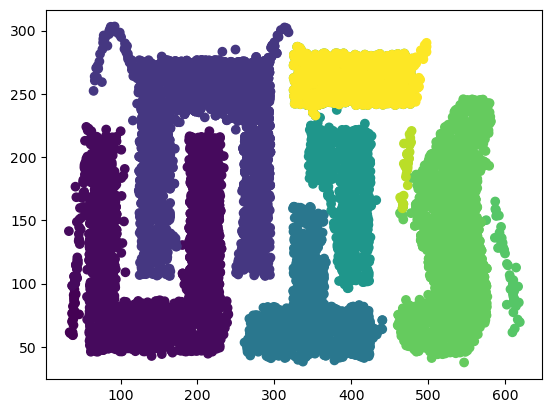

In [30]:
plt.scatter(merged_t4_8k.x, merged_t4_8k.y, c = merged_t4_8k.group)